<a href="https://colab.research.google.com/github/IamNick25/GC_Optimax_TimeSeries/blob/main/GC_Optimax_final_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf


df1 = pd.read_csv("/content/btcusdt_1h_zelta.csv")

# Renaming the 'datetime' column to 'Date'
df1 = df1.rename(columns={"datetime": "Date"})

# Converting the 'Date' column to datetime
df1['Date'] = pd.to_datetime(df1['Date'])
df1=df1.set_index("Date")


'''daily_basis = df.groupby(df["Date"].dt.date)["close"].mean()
daily_basis = daily_basis.to_frame()
daily_basis = daily_basis.rename(columns={"close": "Price"})
daily_basis.index.name = "Date"
print(daily_basis)

#'Date' column as the index of the DataFrame
df = df.set_index('Date')
weekly_basis = df['close'].resample('W').mean()

# Converting the weekly average Series to a DataFrame
weekly_basis = weekly_basis.to_frame(name='Price')
print(weekly_basis)'''

# The first few rows of the DataFrame
df1.head()
#daily_basis.info()
s=int(0.995*len(df1))
df=df1[:s]




In [ ]:
bitcoin_prices=pd.DataFrame(df["close"]).rename(columns={"close":"Price"})
#bitcoin_prices=weekly_basis
bitcoin_prices.head()
#print(bitcoin_prices["Price"].isna().sum())

,Price
Date,
2018-01-01 05:30:00,13529.01
2018-01-01 06:30:00,13203.06
2018-01-01 07:30:00,13330.18
2018-01-01 08:30:00,13410.03
2018-01-01 09:30:00,13601.01


In [ ]:
a=len(df)
a

34855

In [ ]:
df.tail()


,open,high,low,close,volume
Date,,,,,
2021-12-28 08:30:00,49775.31,49889.58,49500.00,49828.06,1863.06312
2021-12-28 09:30:00,49828.07,49828.07,48657.12,49054.47,4642.00877
2021-12-28 10:30:00,49050.58,49243.73,48950.00,49200.90,1407.13684
2021-12-28 11:30:00,49200.90,49343.98,49096.67,49218.49,1104.01703
2021-12-28 12:30:00,49218.49,49366.00,49037.23,49227.13,1009.49151


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34855 entries, 2018-01-01 05:30:00 to 2021-12-28 12:30:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    34855 non-null  float64
 1   high    34855 non-null  float64
 2   low     34855 non-null  float64
 3   close   34855 non-null  float64
 4   volume  34855 non-null  float64
dtypes: float64(5)
memory usage: 1.6 MB


In [ ]:
bitcoin_prices.tail()

,Price
Date,
2021-12-28 08:30:00,49828.06
2021-12-28 09:30:00,49054.47
2021-12-28 10:30:00,49200.90
2021-12-28 11:30:00,49218.49
2021-12-28 12:30:00,49227.13


In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd


X = bitcoin_prices["Price"].values.reshape(-1, 1)

# Creating the KMeans Clusters
kmeans = KMeans(n_clusters=3)  # Adjusting the number of clusters as needed
kmeans.fit(X)

# Identifying the centroids and calculating distances to them
centroids = kmeans.cluster_centers_
distance = np.min(cdist(X, centroids, "euclidean"), axis=1)

# Defining the threshold for outliers and identifying them
threshold = np.percentile(distance, 67)  # Adjusting percentile as needed
outliers = distance > threshold

# Replacing outliers with NaN
bitcoin_prices.loc[outliers, "Price"] = np.nan

# Calculating the moving average and using it to fill NaN values
bitcoin_prices["Moving_Average"] = bitcoin_prices["Price"].rolling(window=5, min_periods=1).mean()
bitcoin_prices["Price"].fillna(bitcoin_prices["Moving_Average"], inplace=True)

# Forward fill to handle NaN values at the start
bitcoin_prices["Price"].fillna(method='ffill', inplace=True)

# Backward fill to handle NaN values at the end
bitcoin_prices["Price"].fillna(method='bfill', inplace=True)

# Removing the temporary 'Moving_Average' column if no longer needed
bitcoin_prices.drop(columns=['Moving_Average'], inplace=True)

# Checking to ensure no NaN values remain
print(bitcoin_prices["Price"].isna().sum())

0


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


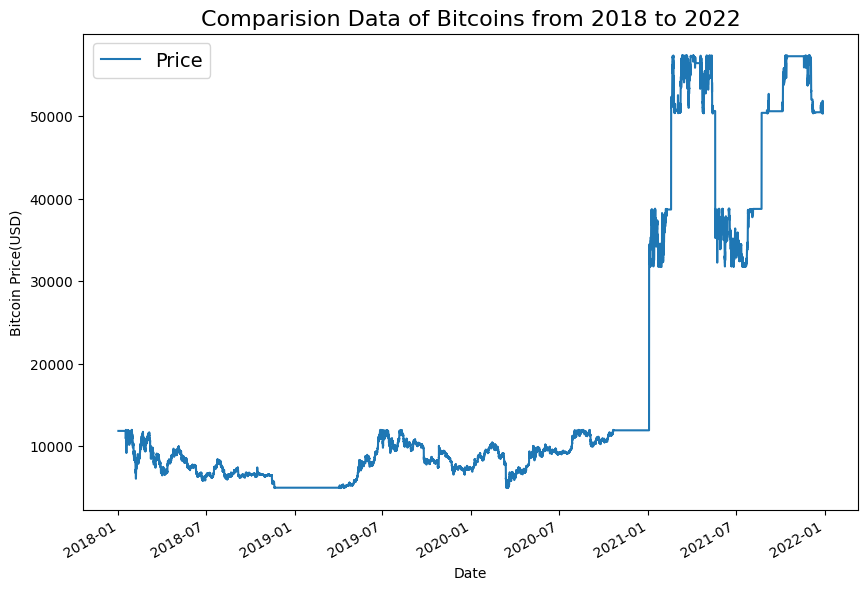

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("Bitcoin Price(USD)")
plt.title("Comparision Data of Bitcoins from 2018 to 2022", fontsize=16)
plt.legend(fontsize=14)

In [ ]:
timesteps=bitcoin_prices.index.to_numpy()
prices=bitcoin_prices["Price"].to_numpy()
timesteps[:10],prices[:10]

(array(['2018-01-01T05:30:00.000000000', '2018-01-01T06:30:00.000000000',
        '2018-01-01T07:30:00.000000000', '2018-01-01T08:30:00.000000000',
        '2018-01-01T09:30:00.000000000', '2018-01-01T10:30:00.000000000',
        '2018-01-01T11:30:00.000000000', '2018-01-01T12:30:00.000000000',
        '2018-01-01T13:30:00.000000000', '2018-01-01T14:30:00.000000000'],
       dtype='datetime64[ns]'),
 array([10900.01, 10900.01, 10900.01, 10900.01, 10900.01, 10900.01,
        10900.01, 10900.01, 10900.01, 10900.01]))

In [ ]:
# Splitting the train and test data using indexing

split_size=int(0.8*(len(prices)))

X_train,Y_train=timesteps[:split_size],prices[:split_size]
X_test,Y_test=timesteps[split_size:],prices[split_size:]

a=len(X_train);b=len(Y_train);c=len(X_test);d=len(Y_test);
a,b,c,d

(27884, 27884, 6971, 6971)

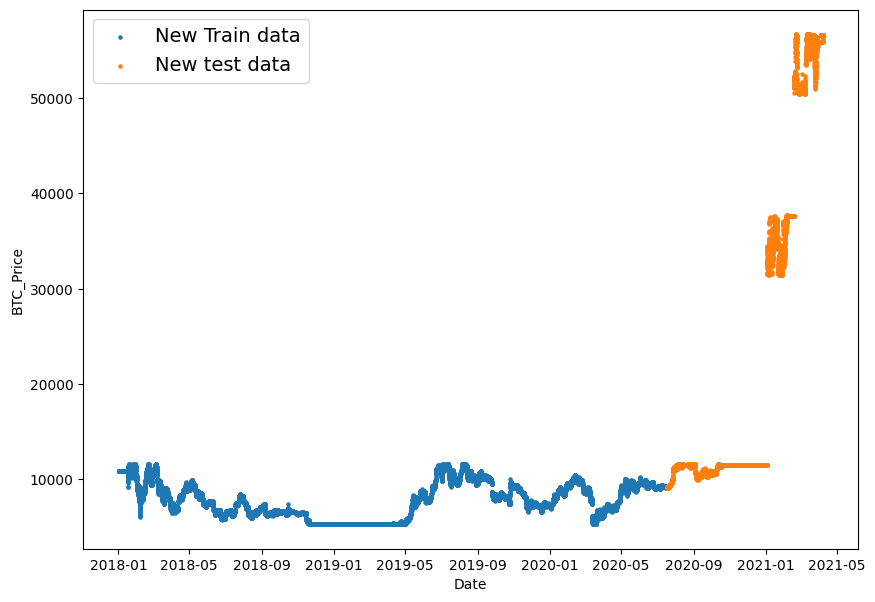

In [ ]:
# Making a desirable train test split to avoid shuffling of test data in between train data for future simulations

plt.figure(figsize=(10,7))
plt.scatter(X_train,Y_train,s=5,label="New Train data")
plt.scatter(X_test,Y_test,s=5,label="New test data")
plt.xlabel("Date")
plt.ylabel("BTC_Price")
plt.legend(fontsize=14)
plt.show();

In [ ]:
def plot_time_series(timesteps,values,format=".",start=0,end=None,label=None):
  plt.plot(timesteps[start:end],values[start:end],format,label=label)
  plt.xlabel("Date")
  plt.ylabel("BTC_Price")
  if label:
    plt.legend(fontsize=14) # To make the label bigger
  plt.grid(True)

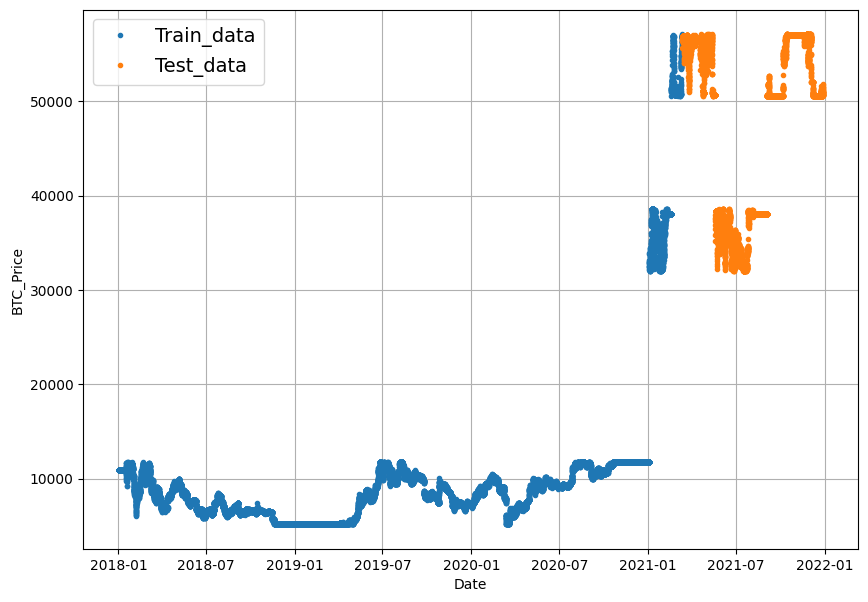

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=Y_train, label="Train_data")
plot_time_series(timesteps=X_test, values=Y_test, label="Test_data")

In [ ]:
#Creating a naive forecast
naive_forecast=Y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([56715.97      , 56500.        , 56386.89      , 55689.99      ,
        56211.83      , 56956.95      , 56311.415     , 56286.25666667,
        56584.39      , 56942.41      ]),
 array([50975.61      , 51020.06      , 50701.44      , 50980.7475    ,
        50899.03666667, 50860.75      , 50701.44      , 50701.44      ,
        50701.44      , 50701.44      ]))

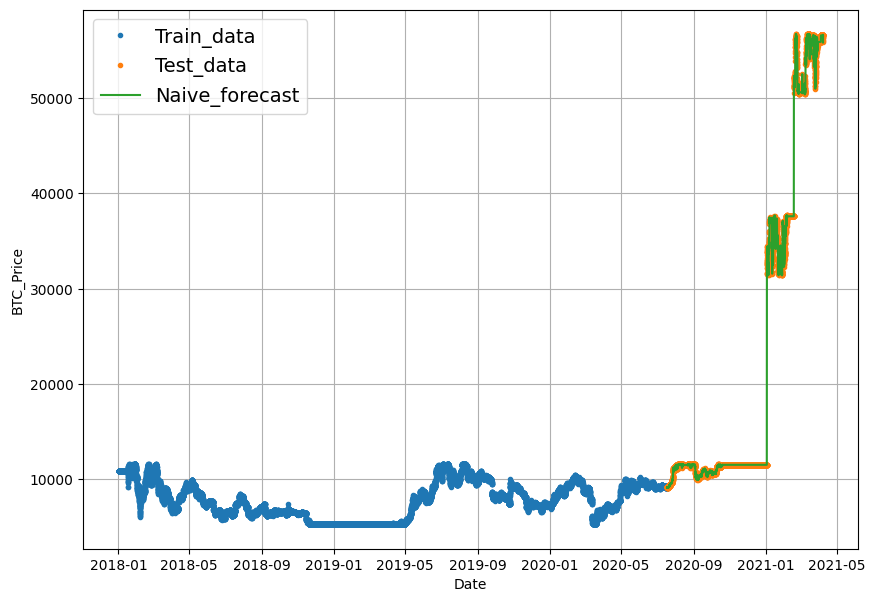

In [ ]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train,values=Y_train,label="Train_data")
plot_time_series(timesteps=X_test,values=Y_test,label="Test_data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive_forecast")

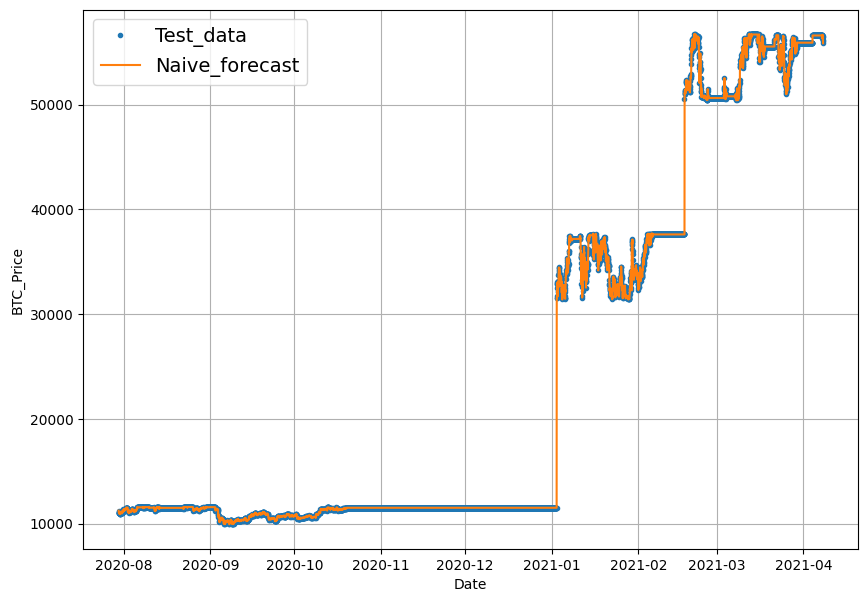

In [ ]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(timesteps=X_test,values=Y_test,start=offset,label="Test_data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,start=offset,format="-",label="Naive_forecast")

In [ ]:
import tensorflow as tf

def mean_absolute_scaled_error(y_true,y_pred):
  mae=tf.reduce_mean(tf.abs(y_true-y_pred))
  mae_naive_no_season=tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  return mae/mae_naive_no_season

In [ ]:
def evaluate_preds(y_true,y_pred):
  y_true=tf.cast(y_true, dtype=tf.float32)
  y_pred=tf.cast(y_pred, dtype=tf.float32)

  mae=tf.keras.metrics.mean_absolute_error(y_true,y_pred)
  mse=tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse=tf.sqrt(mse)
  mape=tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)
  mase=mean_absolute_scaled_error(y_true,y_pred)

  # Accounting for different sized metrics,i.e,
#  if mae is not in its scalar form we can reduce it to one by aggregating across the entire horizon array
  if mae.ndim>0:
    mae=tf.reduce_mean(mae)
    mse=tf.reduce_mean(mse)
    rmse=tf.reduce_mean(rmse)
    mape=tf.reduce_mean(mape)
    mase=tf.reduce_mean(mase)


  return{"mae": mae.numpy(),
         "mse": mse.numpy(),
         "rmse": rmse.numpy(),
         "mape": mape.numpy(),
         "mase": mase.numpy()}

In [ ]:
naive_results=evaluate_preds(y_true=Y_test[1:],y_pred=Y_test[:-1])
naive_results

{'mae': 102.388336,
 'mse': 107606.54,
 'rmse': 328.03436,
 'mape': 0.23502779,
 'mase': 1.0001593}

In [ ]:
HORIZON=1; # Predict one step at a time
WINDOW_SIZE=7 #vTake 7 days to predict the next day output

In [ ]:
def get_labelled_windows(x,horizon=1):
  return x[:,:-horizon], x[:,-horizon:]

In [ ]:
test_window, test_label=get_labelled_windows(tf.expand_dims(tf.range(8)+1,axis=0),horizon=HORIZON)
print(f"Window:{tf.squeeze(test_window).numpy()}->Label:{tf.squeeze(test_label).numpy()}")

Window:[1 2 3 4 5 6 7]->Label:8


In [ ]:
import numpy as np

# Turning a 1D array into a 2D array of sequential window size (Sliding window technique)
def make_windows(x, window_size=7, horizon=1):
  window_step= np.expand_dims(np.arange(window_size+horizon),axis=0) # Create a window of specific window_size
  window_indexes=window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T # To account for 0 index
  windowed_array=x[window_indexes]#Create the step windowed array

  windows,labels=get_labelled_windows(windowed_array,horizon=horizon)
  return windows, labels

In [ ]:
full_windows,full_labels=make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)

print(len(full_windows))
print(len(full_labels))

34848
34848


In [ ]:
n=3
for i in range(n):
  print(f"full_window:{full_windows[i]}--> label:{full_labels[i]}")

full_window:[10900.01 10900.01 10900.01 10900.01 10900.01 10900.01 10900.01]--> label:[10900.01]
full_window:[10900.01 10900.01 10900.01 10900.01 10900.01 10900.01 10900.01]--> label:[10900.01]
full_window:[10900.01 10900.01 10900.01 10900.01 10900.01 10900.01 10900.01]--> label:[10900.01]


In [ ]:
for i in range(3):
  print(f"full_window:{full_windows[i-3]}--> label:{full_labels[i-3]}")

full_window:[51020.06       50701.44       50980.7475     50899.03666667
 50860.75       50701.44       50701.44      ]--> label:[50701.44]
full_window:[50701.44       50980.7475     50899.03666667 50860.75
 50701.44       50701.44       50701.44      ]--> label:[50701.44]
full_window:[50980.7475     50899.03666667 50860.75       50701.44
 50701.44       50701.44       50701.44      ]--> label:[50701.44]


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):

  split_size=int(len(windows)*0.8)


  train_windows = windows[:split_size]
  train_labels=labels[:split_size]
  test_windows=windows[split_size:]
  test_labels=labels[split_size:]




  return train_windows, train_labels, test_windows, test_labels

In [ ]:
train_windows,train_labels,test_windows,test_labels= make_train_test_splits(full_windows,full_labels)
print(len(train_windows),len(train_labels),len(test_windows),len(test_labels))

27878 27878 6970 6970


In [ ]:
train_windows[:5],train_labels[:5]

(array([[10900.01, 10900.01, 10900.01, 10900.01, 10900.01, 10900.01,
         10900.01],
        [10900.01, 10900.01, 10900.01, 10900.01, 10900.01, 10900.01,
         10900.01],
        [10900.01, 10900.01, 10900.01, 10900.01, 10900.01, 10900.01,
         10900.01],
        [10900.01, 10900.01, 10900.01, 10900.01, 10900.01, 10900.01,
         10900.01],
        [10900.01, 10900.01, 10900.01, 10900.01, 10900.01, 10900.01,
         10900.01]]),
 array([[10900.01],
        [10900.01],
        [10900.01],
        [10900.01],
        [10900.01]]))

In [ ]:
df2=df1[s:]

cross=df2.drop(["open","high","low","volume"],axis=1)
cross=cross.rename(columns={"close":"Price"})
cross.tail()

,Price
Date,
2022-01-12 01:30:00,42800.38
2022-01-12 02:30:00,42659.20
2022-01-12 03:30:00,42713.13
2022-01-12 04:30:00,42729.29
2022-01-12 05:30:00,42675.00


In [ ]:
test_windows[:5],test_labels[:5]

(array([[9121.64, 9109.94, 9109.99, 9123.  , 9117.69, 9138.92, 9162.87],
        [9109.94, 9109.99, 9123.  , 9117.69, 9138.92, 9162.87, 9161.58],
        [9109.99, 9123.  , 9117.69, 9138.92, 9162.87, 9161.58, 9152.19],
        [9123.  , 9117.69, 9138.92, 9162.87, 9161.58, 9152.19, 9148.37],
        [9117.69, 9138.92, 9162.87, 9161.58, 9152.19, 9148.37, 9152.09]]),
 array([[9161.58],
        [9152.19],
        [9148.37],
        [9152.09],
        [9149.87]]))

In [ ]:
print(np.isnan(train_windows).any())
print(np.isinf(train_labels).any())
print(np.isnan(test_windows).any())
print(np.isinf(test_windows).any())
print(np.isnan(test_labels).any())
print(np.isinf(test_labels).any())
print(np.isnan(cross_windows).any())
print(np.isnan(cross_labels).any())

False
False
False
False
False
False
False
False


In [ ]:
# Modelling a checkpoint for callbacks
# If at epoch e.x: 55, model shows best performance and initial epoch is set at 100, then it is retrieved early to avoid overfitting issues
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),#Create filepath to save model
                                            verbose=0, # To get limited amount of text
                                            save_best_only=True)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_1=tf.keras.Sequential([
    layers.Dense(12,activation="relu"),
    layers.Dense(HORIZON,activation="linear")
], name="model_1_Dense")

model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
BATCH_SIZE=128

model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            validation_data=(test_windows, test_labels),
            batch_size=BATCH_SIZE,
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
174/174 [==============================] - 2s 6ms/step - loss: 132.4321 - mae: 132.4321 - val_loss: 155.7237 - val_mae: 155.7237
Epoch 2/100
174/174 [==============================] - 1s 5ms/step - loss: 55.3791 - mae: 55.3791 - val_loss: 143.5866 - val_mae: 143.5866
Epoch 3/100
174/174 [==============================] - 1s 3ms/step - loss: 54.0082 - mae: 54.0082 - val_loss: 152.1828 - val_mae: 152.1828
Epoch 4/100
174/174 [==============================] - 1s 4ms/step - loss: 55.1132 - mae: 55.1132 - val_loss: 161.1522 - val_mae: 161.1522
Epoch 5/100
174/174 [==============================] - 1s 5ms/step - loss: 55.6213 - mae: 55.6213 - val_loss: 138.6259 - val_mae: 138.6259
Epoch 6/100
174/174 [==============================] - 1s 4ms/step - loss: 54.2202 - mae: 54.2202 - val_loss: 153.2001 - val_mae: 153.2001
Epoch 7/100
174/174 [==============================] - 1s 6ms/step - loss: 53.6575 - mae: 53.6575 - val_loss: 131.1174 - val_mae: 131.1174
Epoch 8/100
174/174 [====

In [ ]:
model_1.evaluate(cross_windows,cross_labels)

111/111 [==============================] - 0s 3ms/step - loss: 155.9468 - mae: 155.9468


[155.94683837890625, 155.94683837890625]

In [ ]:
model_1=tf.keras.models.load_model("/content/model_experiments/model_1_Dense")
model_1.evaluate(cross_windows,cross_labels)

111/111 [==============================] - 0s 2ms/step - loss: 85.1154 - mae: 85.1154


[85.11536407470703, 85.11536407470703]

In [ ]:
def make_preds(model,input_data):

  #input_data is the windowed data
  forecast=model.predict(input_data)
  return tf.squeeze(forecast) # To make it into a 1D array of forecast format

In [ ]:
model_1_preds=make_preds(model_1,cross_windows)

print(len(model_1_preds))
print(model_1_preds[:10])

111/111 [==============================] - 0s 2ms/step
3521
tf.Tensor(
[39729.016 39729.016 39729.016 39729.016 39729.016 39729.016 39729.016
 39729.016 39729.016 39729.016], shape=(10,), dtype=float32)


In [ ]:
model_1_results=evaluate_preds(y_true=tf.squeeze(cross_labels),
                               y_pred=model_1_preds)
model_1_results

{'mae': 85.11537,
 'mse': 74305.914,
 'rmse': 272.5911,
 'mape': 0.16060379,
 'mase': 1.2518048}

In [ ]:
naive_results

{'mae': 170.06363,
 'mse': 175817.5,
 'rmse': 419.30597,
 'mape': 0.41459334,
 'mase': 0.99985796}

ValueError: x and y must have same first dimension, but have shapes (6740, 7) and (3221,)

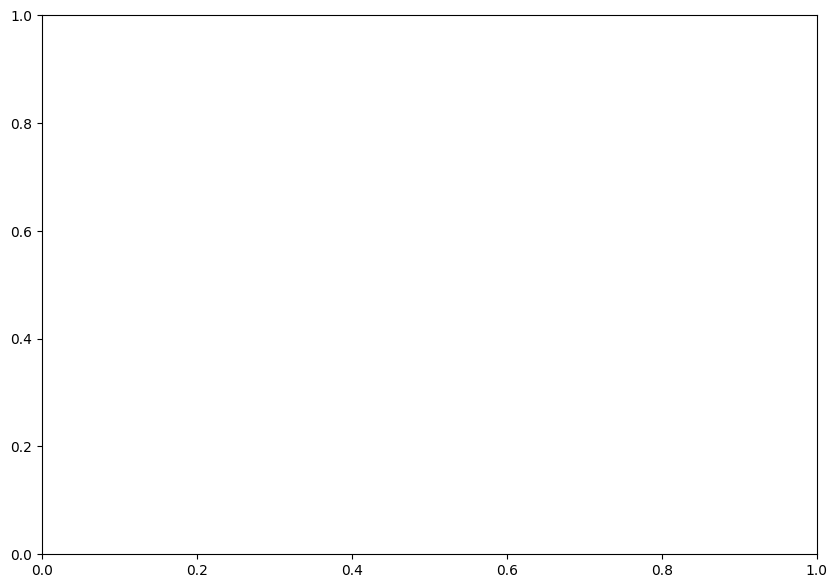

In [ ]:
# Visualising the model and comparing with test data
offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps= X_test[-len(test_windows):], values=cross_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps= X_test[-len(test_windows):], values=model_1_preds, start=offset,format="-", label="Model_1_preds")

In [ ]:
HORIZON=1
WINDOW_SIZE=30

In [ ]:
full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE, horizon=HORIZON)
print(len(full_windows), len(full_labels))
full_windows[:5], full_labels[:5]

35178 35178


(array([[12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84],
        [12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84],
        [12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 12868.84, 12868.84, 12868.84, 12868.84,
         12868.84, 12868.84, 128

In [ ]:
train_windows, train_labels,test_windows, test_labels,cross_windows, cross_labels=make_train_test_splits(windows=full_windows, labels=full_labels)
print(len(train_windows),len(test_windows),len(train_labels),len(test_labels))

24624 7036 24624 7036


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

#Building the model
model_2=tf.keras.Sequential([
    layers.Dense(512,activation="relu"),
    layers.Dense(512,activation="relu"),
    layers.Dense(512,activation="relu"),
    layers.Dense(HORIZON,activation="linear")
],name="model_2_dense")

#Compiling the model

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(lr=0.01),
                metrics=["mae"])
# Fitting the model

model_2.fit(x=train_windows,
            y=train_labels,
            epochs=700,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)],
            batch_size=128,
            verbose=1)

Epoch 1/700
193/193 [==============================] - 3s 7ms/step - loss: 404.6422 - mae: 404.6422 - val_loss: 1201.9315 - val_mae: 1201.9315
Epoch 2/700
193/193 [==============================] - 1s 7ms/step - loss: 209.5623 - mae: 209.5623 - val_loss: 588.9480 - val_mae: 588.9480
Epoch 3/700
193/193 [==============================] - 1s 4ms/step - loss: 163.5541 - mae: 163.5541 - val_loss: 648.3447 - val_mae: 648.3447
Epoch 4/700
193/193 [==============================] - 1s 4ms/step - loss: 173.7777 - mae: 173.7777 - val_loss: 1138.9312 - val_mae: 1138.9312
Epoch 5/700
193/193 [==============================] - 1s 4ms/step - loss: 180.1623 - mae: 180.1623 - val_loss: 914.7352 - val_mae: 914.7352
Epoch 6/700
193/193 [==============================] - 1s 4ms/step - loss: 142.8036 - mae: 142.8036 - val_loss: 669.7880 - val_mae: 669.7880
Epoch 7/700
193/193 [==============================] - 1s 4ms/step - loss: 136.7720 - mae: 136.7720 - val_loss: 745.6586 - val_mae: 745.6586
Epoch 8/7

KeyboardInterrupt: 

In [ ]:
model_2.evaluate(cross_windows,cross_labels)

220/220 [==============================] - 0s 2ms/step - loss: 333.8637 - mae: 333.8637


[333.8636779785156, 333.8636779785156]

In [ ]:
model_2=tf.keras.models.load_model("/content/model_experiments/model_2_dense")
model_2.evaluate(cross_windows,cross_labels)

220/220 [==============================] - 1s 3ms/step - loss: 264.8376 - mae: 264.8376


[264.8375549316406, 264.8375549316406]

In [ ]:
model_2_preds=make_preds(model=model_2,
                         input_data=cross_windows)


220/220 [==============================] - 1s 2ms/step


In [ ]:
model_2_preds.shape, cross_labels.shape # We have to squeeze the dimensions of test labels to compare them with model_2_preds or just squeeze them to 1D array

(TensorShape([7036]), (7036, 1))

In [ ]:
model_2_results=evaluate_preds(y_true=tf.squeeze(cross_labels),
                               y_pred=model_2_preds)
model_2_results

{'mae': 264.83762,
 'mse': 153160.48,
 'rmse': 391.35724,
 'mape': 0.5680046,
 'mase': 1.0250063}

In [ ]:
naive_results

{'mae': 258.4955,
 'mse': 143502.08,
 'rmse': 378.81668,
 'mape': 0.5539432,
 'mase': 0.99986994}

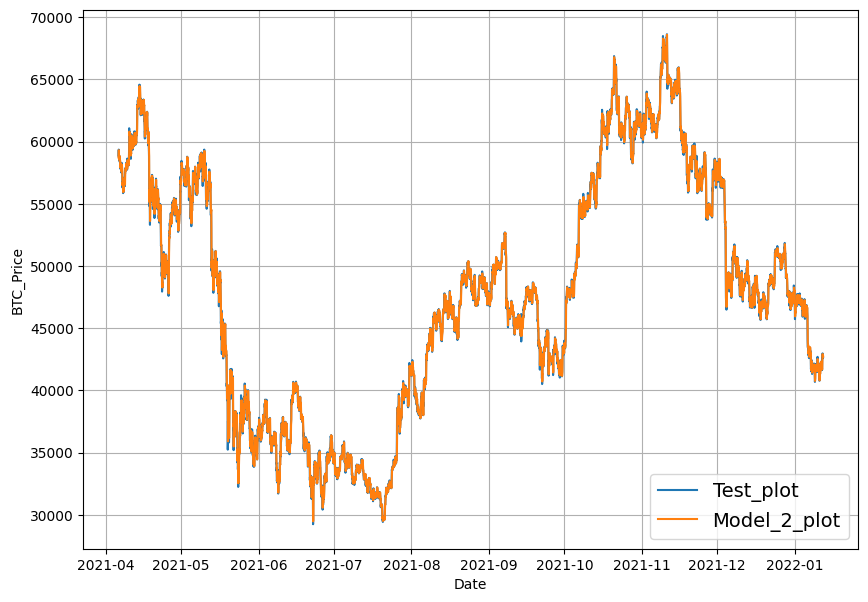

In [ ]:
# Visualising the model
offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=cross_labels[:,0], start=offset,format="-", label="Test_plot")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="Model_2_plot")

In [ ]:
WINDOW_SIZE=30
HORIZON=7

In [ ]:
# Making the windowed data first by sliding window technique

full_windows, full_labels= make_windows(prices,window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows),len(full_labels)

(35172, 35172)

In [ ]:
# Now making the training and test split

train_windows, train_labels, test_windows, test_labels= make_train_test_splits(windows=full_windows,
                                                                               labels=full_labels)

print(len(train_windows),len(train_labels),len(test_windows),len(test_labels))

28137 28137 7035 7035


In [ ]:
# Now making the model_3

import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

model_3= tf.keras.Sequential([
    layers.Dense(128,activation="relu"),
    layers.Dense(128,activation="relu"),
    layers.Dense(HORIZON)
],name="model_3_dense")

# Compiling the  model
model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"])
#Fitting the model
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            validation_data=(test_windows,test_labels),
            batch_size=128,
            verbose=True,
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
220/220 [==============================] - 2s 6ms/step - loss: 33973040.0000 - mae: 33973040.0000 - val_loss: 45139.9336 - val_mae: 45139.9336
Epoch 2/100
220/220 [==============================] - 1s 5ms/step - loss: 6633.9985 - mae: 6633.9985 - val_loss: 41214.2070 - val_mae: 41214.2070
Epoch 3/100
220/220 [==============================] - 1s 5ms/step - loss: 5506.1338 - mae: 5506.1338 - val_loss: 40118.3945 - val_mae: 40118.3945
Epoch 4/100
220/220 [==============================] - 1s 5ms/step - loss: 4985.1528 - mae: 4985.1528 - val_loss: 39650.7969 - val_mae: 39650.7969
Epoch 5/100
220/220 [==============================] - 1s 5ms/step - loss: 4843.2930 - mae: 4843.2930 - val_loss: 39555.1445 - val_mae: 39555.1445
Epoch 6/100
220/220 [==============================] - 1s 5ms/step - loss: 4831.3291 - mae: 4831.3291 - val_loss: 39560.5508 - val_mae: 39560.5508
Epoch 7/100
220/220 [==============================] - 1s 7ms/step - loss: 4830.2871 - mae: 4830.2871 - val_lo

In [ ]:
model_3=tf.keras.models.load_model("/content/model_experiments/model_3_dense")
model_3.evaluate(test_windows,test_labels)

220/220 [==============================] - 1s 2ms/step - loss: 39476.1406 - mae: 39476.1406


[39476.140625, 39476.140625]

In [ ]:
model_3_preds=make_preds(model=model_3,
                         input_data=test_windows)
model_3_results=evaluate_preds(y_true=test_labels,
                               y_pred=model_3_preds)
model_3_results

220/220 [==============================] - 0s 1ms/step


{'mae': 39476.14,
 'mse': 1650643000.0,
 'rmse': 39478.312,
 'mape': 81.15565,
 'mase': 152.71877}

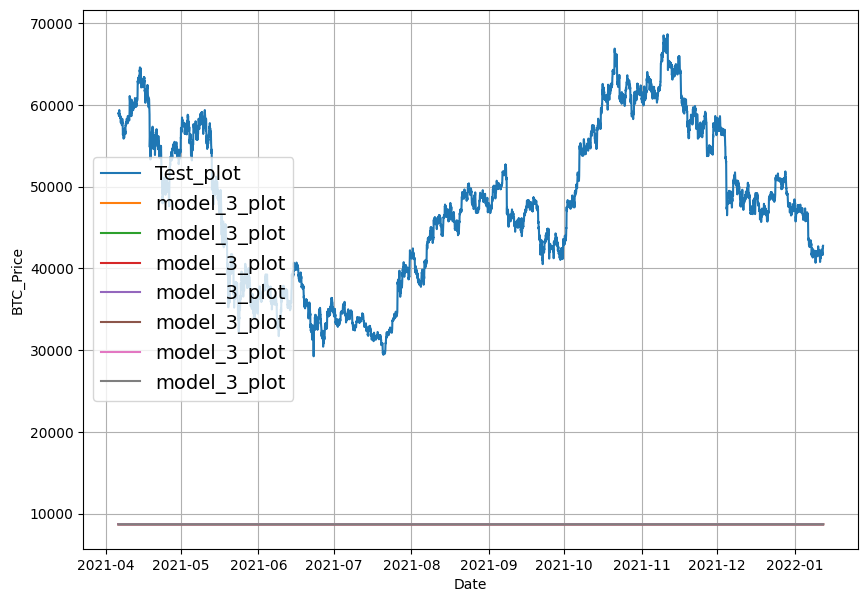

In [ ]:
# Visualising the model

offset=300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test_plot",format="-")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_3_preds,
                 start=offset,
                 label="model_3_plot",
                 format="-")

In [ ]:
# NBeats Architecture
import tensorflow as tf
from tensorflow.keras import layers
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size=input_size
    self.theta_size=theta_size
    self.horizon=horizon
    self.n_neurons=n_neurons
    self.n_layers=n_layers

    self.hidden=[tf.keras.layers.Dense(n_neurons,activation="relu") for _ in range(n_layers)]
    self.theta_layer=tf.keras.layers.Dense(theta_size,activation="linear",name="theta")

  def call(self,inputs):
      x=inputs
      for layer in self.hidden:
        x=layer(x)
      theta=self.theta_layer(x)
      backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
      return backcast, forecast

In [ ]:
dummy_nbeats_block_layer=NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)
dummy_inputs=tf.expand_dims(tf.range(WINDOW_SIZE)+1,axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.44823292  0.5434543  -1.0528698   0.17576554  0.996479   -0.93200815
  0.4491218 ]
Forecast: 0.32560575008392334


In [ ]:
HORIZON=1
WINDOW_SIZE=7

In [ ]:
bitcoin_prices_nbeats=bitcoin_prices.copy()
cross_prices_nbeats=cross.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"]=bitcoin_prices_nbeats["Price"].shift(periods=i+1)
  cross_prices_nbeats[f"Price+{i+1}"]=cross_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()
cross_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2021-12-28 20:30:00,48937.48,49078.29,49024.57,49100.37,49200.39,49034.57,49027.44,49377.69
2021-12-28 21:30:00,48627.97,48937.48,49078.29,49024.57,49100.37,49200.39,49034.57,49027.44
2021-12-28 22:30:00,48030.43,48627.97,48937.48,49078.29,49024.57,49100.37,49200.39,49034.57
2021-12-28 23:30:00,47792.71,48030.43,48627.97,48937.48,49078.29,49024.57,49100.37,49200.39
2021-12-29 00:30:00,47689.46,47792.71,48030.43,48627.97,48937.48,49078.29,49024.57,49100.37


In [ ]:
X=bitcoin_prices_nbeats.dropna().drop("Price",axis=1)
y=bitcoin_prices_nbeats.dropna()["Price"]

X1=cross_prices_nbeats.dropna().drop("Price",axis=1)
y1=cross_prices_nbeats.dropna()["Price"]

split_size=int(len(X)*0.8)

X_train,Y_train=X[:split_size],y[:split_size]
X_test,Y_test=X[split_size:],y[split_size:]
X_cross,Y_cross=X1,y1

print(len(X_train),len(Y_train),len(X_test),len(Y_test),len(X_cross),len(Y_cross))
X_cross.tail()

27878 27878 6970 6970 346 346


,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2022-01-12 01:30:00,42972.05,42755.00,42549.01,42705.24,41733.93,41642.00,41701.52
2022-01-12 02:30:00,42800.38,42972.05,42755.00,42549.01,42705.24,41733.93,41642.00
2022-01-12 03:30:00,42659.20,42800.38,42972.05,42755.00,42549.01,42705.24,41733.93
2022-01-12 04:30:00,42713.13,42659.20,42800.38,42972.05,42755.00,42549.01,42705.24
2022-01-12 05:30:00,42729.29,42713.13,42659.20,42800.38,42972.05,42755.00,42549.01


In [ ]:
train_features_dataset=tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset=tf.data.Dataset.from_tensor_slices(Y_train)

test_features_dataset=tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset=tf.data.Dataset.from_tensor_slices(Y_test)

cross_features_dataset=tf.data.Dataset.from_tensor_slices(X_cross)
cross_labels_dataset=tf.data.Dataset.from_tensor_slices(Y_cross)


train_dataset=tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset=tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))
cross_dataset=tf.data.Dataset.zip((cross_features_dataset,cross_labels_dataset))

BATCH_SIZE=1024# As per NBeats Paper
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
cross_dataset=cross_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset,cross_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
# Hyperparameter Tuning of our Nbeats Custom_layer

N_EPOCHS=5000
N_NEURONS=512
N_LAYERS=4
N_STACKS=30

INPUT_SIZE=WINDOW_SIZE*HORIZON # In paper "lookback" which was given
THETA_SIZE=WINDOW_SIZE+HORIZON

INPUT_SIZE,THETA_SIZE

(7, 8)

In [ ]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# Create stacks of blocks
for i, _ in enumerate(range(1,N_STACKS)): # first stack is already creted

  #Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])

Epoch 1/5000
28/28 [==============================] - 50s 131ms/step - loss: 7921.6196 - mae: 7921.6196 - mse: 773696448.0000 - val_loss: 3792.9834 - val_mae: 3792.9836 - val_mse: 15094371.0000 - lr: 0.0010
Epoch 2/5000
28/28 [==============================] - 2s 67ms/step - loss: 773.9892 - mae: 773.9892 - mse: 1959331.1250 - val_loss: 5499.1860 - val_mae: 5499.1860 - val_mse: 31568376.0000 - lr: 0.0010
Epoch 3/5000
28/28 [==============================] - 2s 73ms/step - loss: 710.6817 - mae: 710.6817 - mse: 1308638.6250 - val_loss: 1727.9343 - val_mae: 1727.9343 - val_mse: 3300590.0000 - lr: 0.0010
Epoch 4/5000
28/28 [==============================] - 2s 68ms/step - loss: 361.2216 - mae: 361.2216 - mse: 513919.4688 - val_loss: 3642.6692 - val_mae: 3642.6692 - val_mse: 13943306.0000 - lr: 0.0010
Epoch 5/5000
28/28 [==============================] - 2s 87ms/step - loss: 295.5403 - mae: 295.5403 - mse: 205617.9219 - val_loss: 1782.6426 - val_mae: 1782.6426 - val_mse: 3490926.5000 - lr: 

In [ ]:
model_7.evaluate(test_dataset)

7/7 [==============================] - 0s 34ms/step - loss: 103.5710 - mae: 103.5710 - mse: 108268.5000


[103.57098388671875, 103.57098388671875, 108268.5]

In [ ]:
model_7_preds=make_preds(model=model_7,
                         input_data=cross_dataset)
model_7_preds[:5]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([49090.37 , 48985.348, 48694.65 , 48147.484, 47847.8  ],
      dtype=float32)>

In [ ]:
model_7_results=evaluate_preds(y_true=Y_cross,
                               y_pred=model_7_preds)

model_7_results

{'mae': 204.10951,
 'mse': 84665.484,
 'rmse': 290.97333,
 'mape': 0.4569865,
 'mase': 0.9880853}

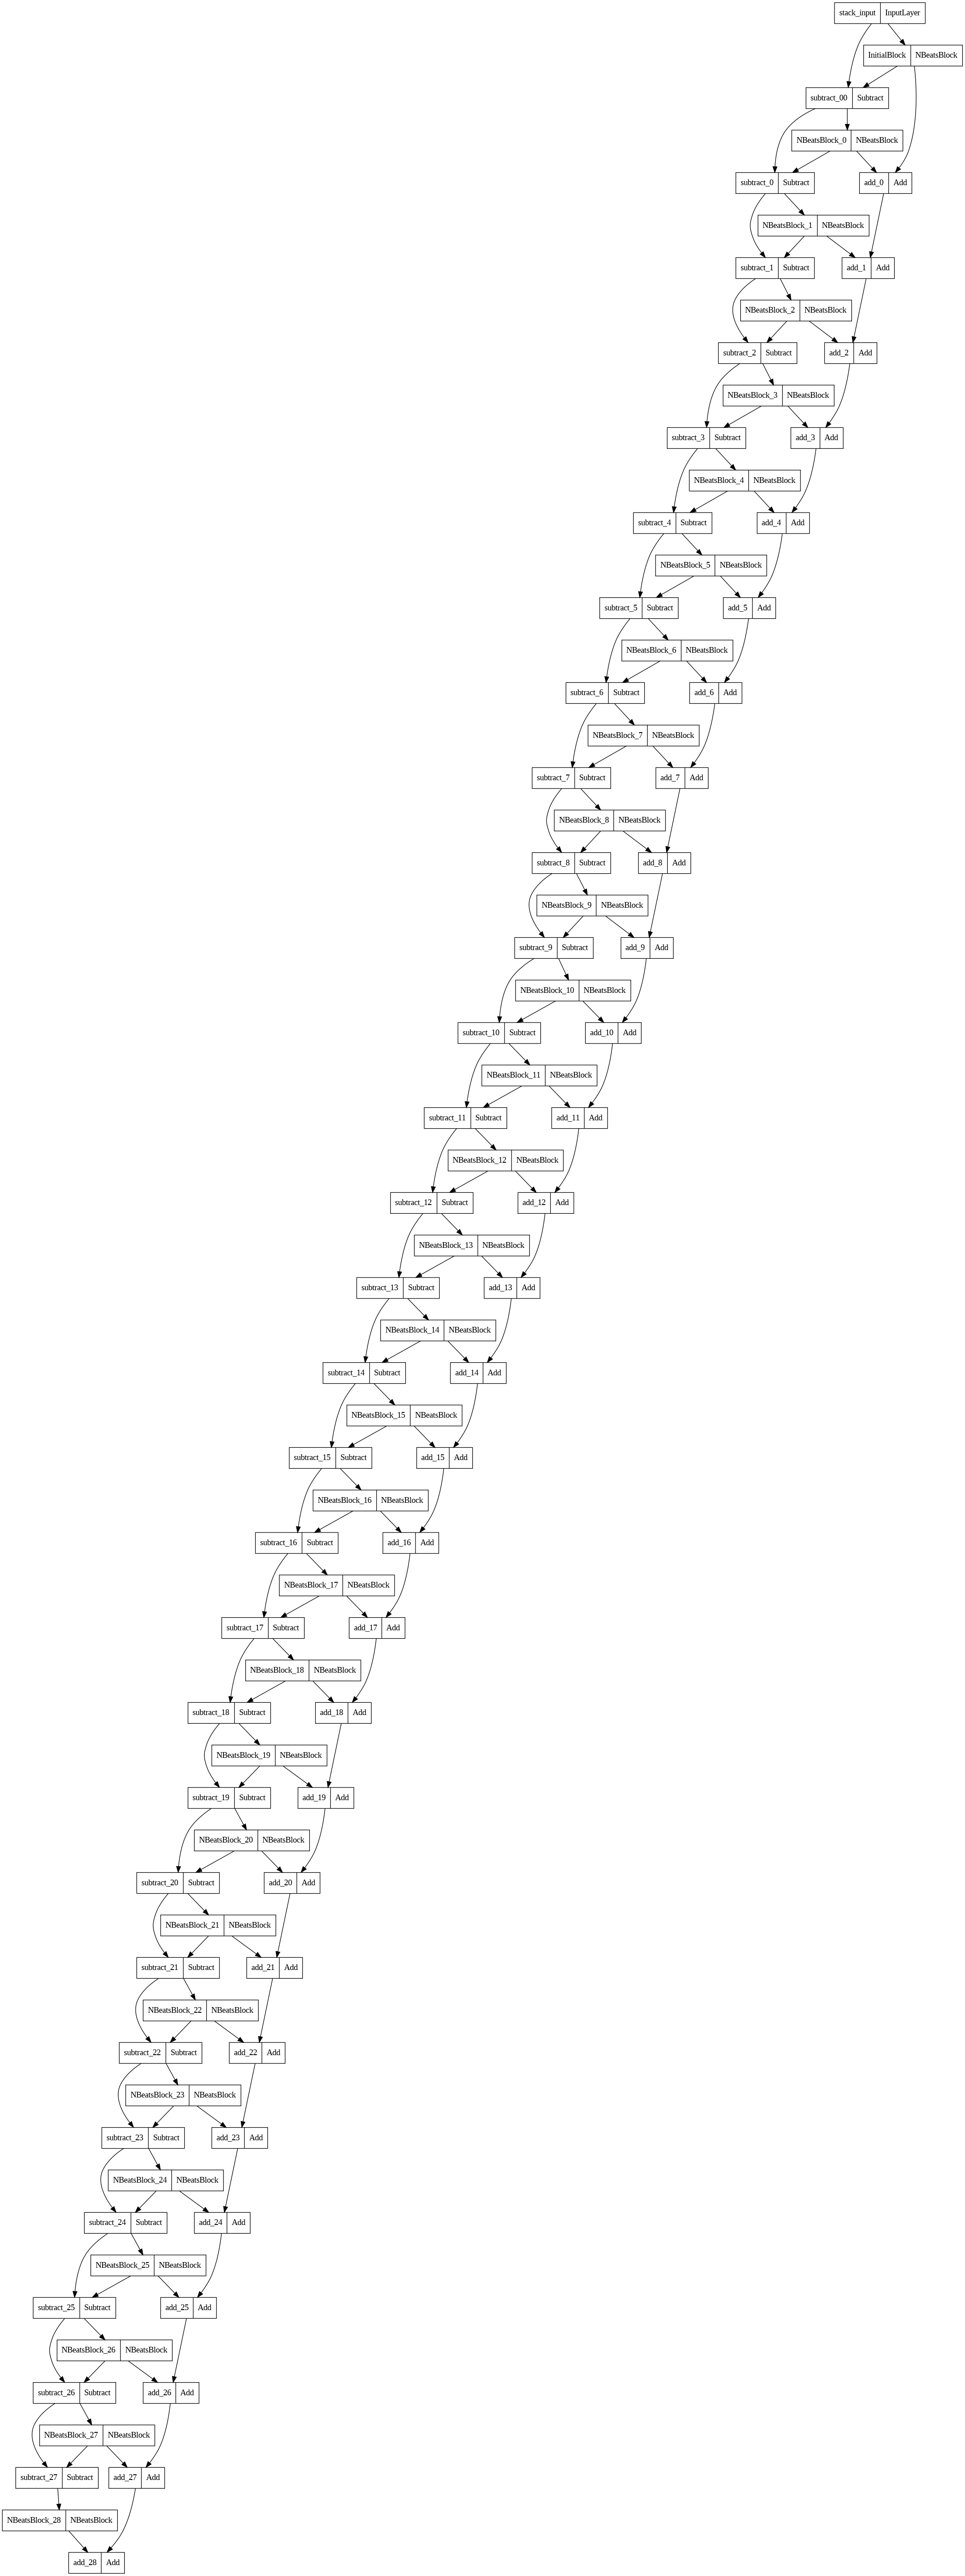

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7)